# Algorithmic Trading

In [37]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import mplfinance as mpf
warnings.filterwarnings('ignore')

In [26]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
#symbols_list Checa se estão corretos

In [27]:
end_date = '2024-4-26'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*5)
df = yf.download(tickers = symbols_list,
                start = start_date,
                end = end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-04-29 A        74.643982   77.330002   78.440002   77.320000   77.470001   
           AAL      33.323235   33.770000   33.990002   33.310001   33.509998   
           AAPL     49.244450   51.152500   51.492500   50.965000   51.099998   
           ABBV     63.994633   80.300003   80.980003   79.910004   80.459999   
           ABT      71.896591   78.269997   78.629997   77.580002   78.559998   
...                       ...         ...         ...         ...         ...   
2024-04-25 XYL     130.610001  130.610001  131.199997  128.100006  129.619995   
           YUM     141.559998  141.559998  142.169998  140.389999  141.979996   
           ZBH     119.750000  119.750000  121.349998  118.769997  120.709999   
           ZBRA    292.529999  292.529999  293.290009  271.630005  274.359985   
           ZTS     153.360001  153.360001  153.589996  150.039993  150.970001   

Price                  volume  
date       ticker              
2019-04-29 A        2177700.0  
           AAL      5558200.0  
           AAPL    88818800.0  
           ABBV     6444500.0  
           ABT      4355000.0  
...                       ...  
2024-04-25 XYL       963600.0  
           YUM      1693100.0  
           ZBH      1078800.0  
           ZBRA      674700.0  
           ZTS      4567200.0  

[625674 rows x 6 columns]

# 2.Calculate features and technical indicators for each stock.


- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume


$$
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
$$


## Candle Graph of APPL

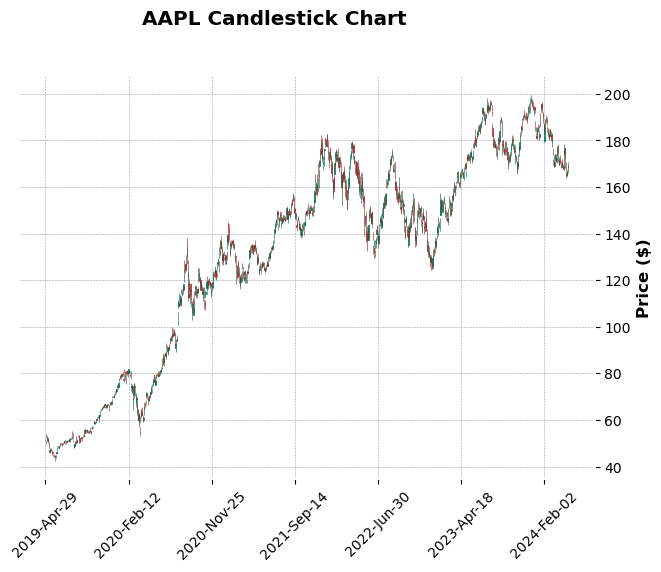

In [38]:
mpf.plot(data, type='candle', style='charles', title='AAPL Candlestick Chart', ylabel='Price ($)')

## Garman Klass Volatility

In [43]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

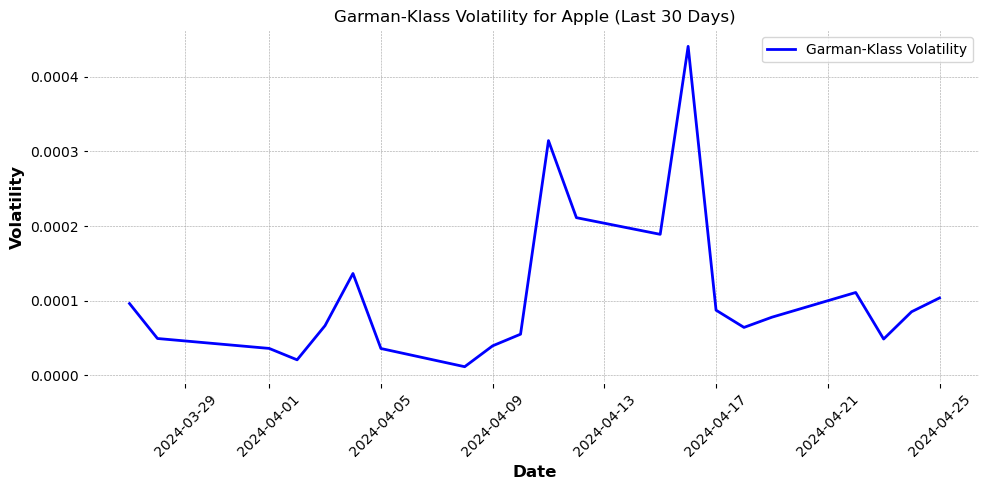

In [57]:
aapl_start_date = pd.to_datetime(end_date)-pd.DateOffset(30)
apple_data = df.loc[(slice(aapl_start_date, end_date), 'AAPL'), :]

#Normalizes the Dataframe for manipulation
apple_data = apple_data.reset_index()
apple_data['date'] = pd.to_datetime(apple_data['date'])

#Makes the graph of volatility
plt.figure(figsize=(10, 5))
plt.plot(apple_data['date'], apple_data['garman_klass_vol'], label='Garman-Klass Volatility', color='blue')
plt.title('Garman-Klass Volatility for Apple (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

## Relative Strengh Index (RSI)

$$
RSI_{\text{step one}} = 100 - \left[ \frac{100}{1 + \frac{\text{Average gain}}{\text{Average loss}}} \right]
$$


In [40]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=14))
# df.xs('ABBV',level=1)['rsi'].plot() 

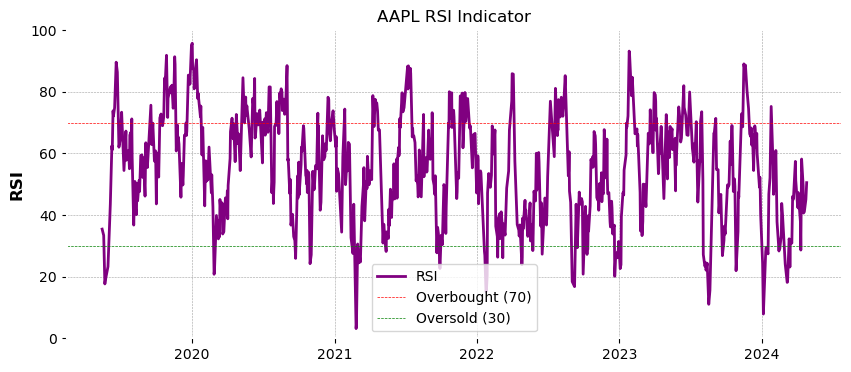

In [39]:
plt.figure(figsize=(10, 4))
plt.title('AAPL RSI Indicator')
plt.plot(data.index, data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', linewidth=0.5, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=0.5, label='Oversold (30)')
plt.ylim([0, 100])
plt.ylabel('RSI')
plt.legend()
plt.show()

## Bollinger Bands

In [70]:
#Fixes the None problem
def safe_bbands1(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 0] 
    else:
        return pd.Series([None] * len(x), index=x.index)  


df['bb_low'] = df.groupby(level=1)['adj close'].transform(safe_bbands1)

def safe_bbands2(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 1] 
    else:
        return pd.Series([None] * len(x), index=x.index)  

# Apply the safe_bbands function
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(safe_bbands2)

def safe_bbands3(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 2]  
    else:
        return pd.Series([None] * len(x), index=x.index)  


df['bb_high'] = df.groupby(level=1)['adj close'].transform(safe_bbands3)

#Joins with df
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

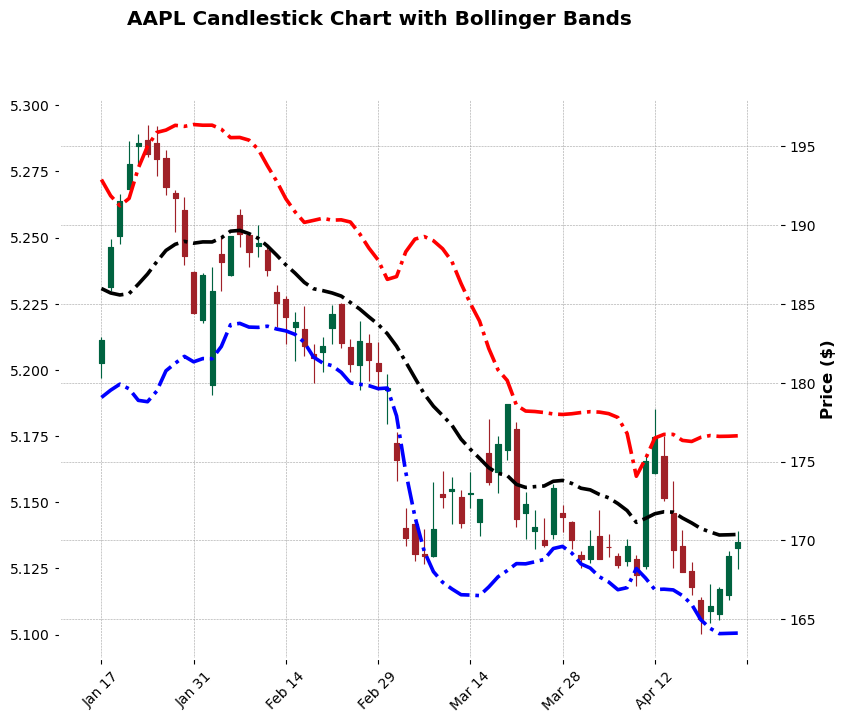

In [71]:
aapl_start_date = pd.to_datetime(end_date)-pd.DateOffset(100)


apple_data = df.loc[(slice(aapl_start_date, end_date), 'AAPL'), :]

# Normalize the DataFrame for manipulation
apple_data = apple_data.reset_index()
apple_data['date'] = pd.to_datetime(apple_data['date'])
apple_data.set_index('date', inplace=True)  # Set 'date' as the index

add_plots = [
    mpf.make_addplot(apple_data['bb_low'], color='blue', linestyle='dashdot'),
    mpf.make_addplot(apple_data['bb_mid'], color='black', linestyle='dashdot'),
    mpf.make_addplot(apple_data['bb_high'], color='red', linestyle='dashdot')
]

# Create the candlestick chart with Bollinger Bands using apple_data
mpf.plot(apple_data, type='candle', style='charles', title='AAPL Candlestick Chart with Bollinger Bands', ylabel='Price ($)', addplot=add_plots, figsize=(10, 8))

## Moving Average Convergence/Divergence

In [73]:
def compute_macd(close):
    macd_result = pandas_ta.macd(close=close, fast=12, slow=26, signal=9)  
    if macd_result is not None and not macd_result.empty:
        macd = macd_result['MACD_12_26_9']
        return macd.sub(macd.mean()).div(macd.std())
    else:
        return pd.Series([None] * len(close), index=close.index)  

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)


Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-04-29 A        74.643982   77.330002   78.440002   77.320000   77.470001   
           AAL      33.323235   33.770000   33.990002   33.310001   33.509998   
           AAPL     49.244450   51.152500   51.492500   50.965000   51.099998   
           ABBV     63.994633   80.300003   80.980003   79.910004   80.459999   
           ABT      71.896591   78.269997   78.629997   77.580002   78.559998   
...                       ...         ...         ...         ...         ...   
2024-04-25 XYL     130.610001  130.610001  131.199997  128.100006  129.619995   
           YUM     141.559998  141.559998  142.169998  140.389999  141.979996   
           ZBH     119.750000  119.750000  121.349998  118.769997  120.709999   
           ZBRA    292.529999  292.529999  293.290009  271.630005  274.359985   
           ZTS     153.360001  153.360001  153.589996  150.039993  150.970001   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-04-29 A        2177700.0         -0.000430        NaN       NaN   
           AAL      5558200.0          0.000192        NaN       NaN   
           AAPL    88818800.0         -0.000475        NaN       NaN   
           ABBV     6444500.0         -0.020162        NaN       NaN   
           ABT      4355000.0         -0.002944        NaN       NaN   
...                       ...               ...        ...       ...   
2024-04-25 XYL       963600.0          0.000264  61.482745  4.843367   
           YUM      1693100.0          0.000076  65.668163  4.914062   
           ZBH      1078800.0          0.000206  35.636078  4.769259   
           ZBRA      674700.0          0.001355  56.172272  5.574158   
           ZTS      4567200.0          0.000178  39.809619  4.957942   

Price                bb_mid   bb_high       atr      macd  
date       ticker                                          
2019-04-29 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-04-25 XYL     4.863772  4.884178 -0.152456  0.249134  
           YUM     4.937850  4.961639 -0.409506  0.421096  
           ZBH     4.821754  4.874250 -0.825956   -0.7325  
           ZBRA    5.654944  5.735729 -0.454850 -0.276747  
           ZTS     5.043798  5.129654  0.759311 -2.317643  

[625674 rows x 13 columns]

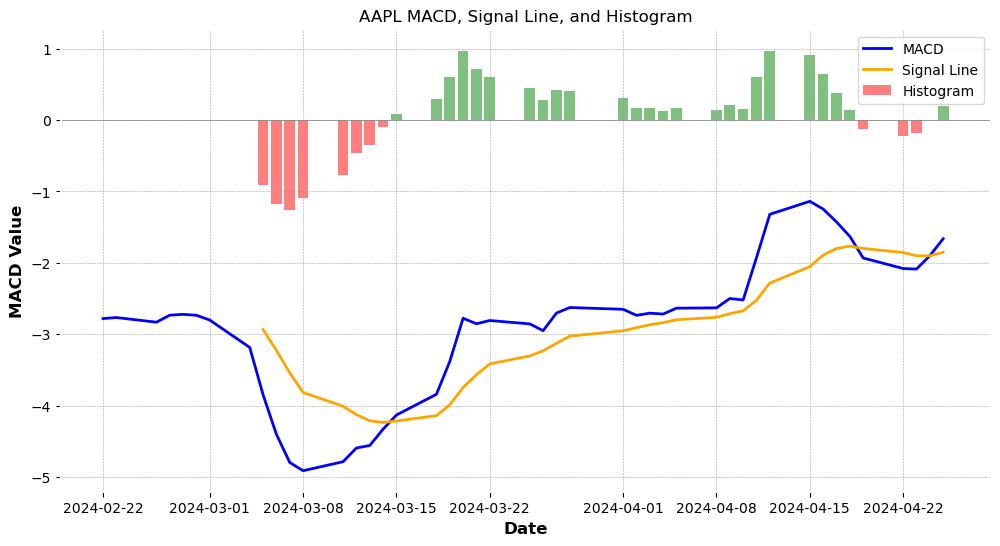

In [75]:
# Convert the Series to DataFrame if necessary, or ensure your data is in DataFrame format
if isinstance(apple_data['adj close'], pd.Series):
    close_prices = apple_data['adj close'].to_frame(name='close')

# Calculate MACD using pandas_ta
macd = pandas_ta.macd(close_prices['close'], fast=12, slow=26, signal=9)

# Add MACD calculations to the original data frame for plotting
apple_data['MACD'] = macd['MACD_12_26_9']
apple_data['Signal'] = macd['MACDs_12_26_9']
apple_data['Histogram'] = macd['MACDh_12_26_9']


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apple_data.index, apple_data['MACD'], label='MACD', color='blue')
ax.plot(apple_data.index, apple_data['Signal'], label='Signal Line', color='orange')
ax.bar(apple_data.index, apple_data['Histogram'], label='Histogram', color=apple_data['Histogram'].apply(lambda x: 'green' if x > 0 else 'red'), alpha=0.5)

ax.axhline(0, color='gray', linewidth=0.5)  # Adds a baseline at 0

ax.set_title('AAPL MACD, Signal Line, and Histogram')
ax.set_xlabel('Date')
ax.set_ylabel('MACD Value')
ax.legend()
plt.show()

## Dolar Volume

In [76]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

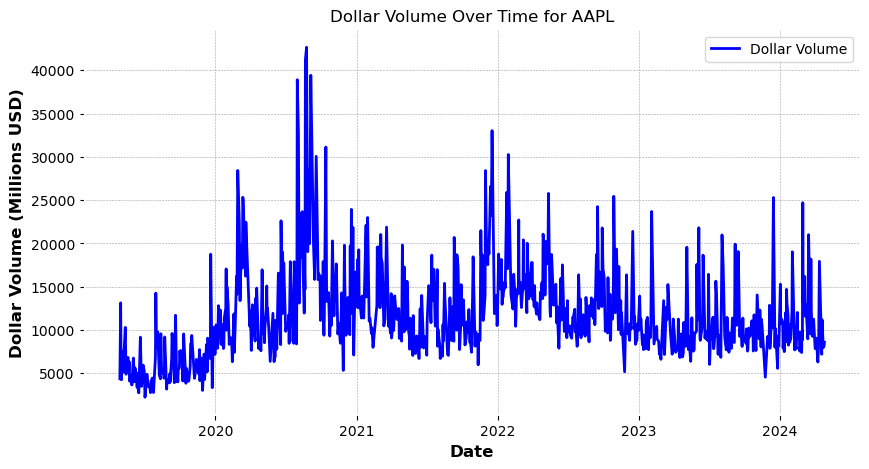

In [81]:
# Reset the index
df_reset = df.reset_index()

# Convert the 'date' column to datetime
df_reset['date'] = pd.to_datetime(df_reset['date'])

# Unstack the data
df_unstacked = df_reset.set_index(['date', 'ticker']).unstack()

# Now plot the data for 'AAPL'
plt.figure(figsize=(10, 5))
plt.plot(df_unstacked.index, df_unstacked[('dollar_volume', 'AAPL')], label='Dollar Volume', color='blue')
plt.title('Dollar Volume Over Time for AAPL')
plt.xlabel('Date')
plt.ylabel('Dollar Volume (Millions USD)')
plt.legend()
plt.grid(True)
plt.show()


# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [82]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-04-29 A        74.643982   77.330002   78.440002   77.320000   77.470001   
           AAL      33.323235   33.770000   33.990002   33.310001   33.509998   
           AAPL     49.244450   51.152500   51.492500   50.965000   51.099998   
           ABBV     63.994633   80.300003   80.980003   79.910004   80.459999   
           ABT      71.896591   78.269997   78.629997   77.580002   78.559998   
...                       ...         ...         ...         ...         ...   
2024-04-25 XYL     130.610001  130.610001  131.199997  128.100006  129.619995   
           YUM     141.559998  141.559998  142.169998  140.389999  141.979996   
           ZBH     119.750000  119.750000  121.349998  118.769997  120.709999   
           ZBRA    292.529999  292.529999  293.290009  271.630005  274.359985   
           ZTS     153.360001  153.360001  153.589996  150.039993  150.970001   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-04-29 A        2177700.0         -0.000430        NaN       NaN   
           AAL      5558200.0          0.000192        NaN       NaN   
           AAPL    88818800.0         -0.000475        NaN       NaN   
           ABBV     6444500.0         -0.020162        NaN       NaN   
           ABT      4355000.0         -0.002944        NaN       NaN   
...                       ...               ...        ...       ...   
2024-04-25 XYL       963600.0          0.000264  61.482745  4.843367   
           YUM      1693100.0          0.000076  65.668163  4.914062   
           ZBH      1078800.0          0.000206  35.636078  4.769259   
           ZBRA      674700.0          0.001355  56.172272  5.574158   
           ZTS      4567200.0          0.000178  39.809619  4.957942   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2019-04-29 A            NaN       NaN       NaN       NaN     162.552199  
           AAL          NaN       NaN       NaN       NaN     185.217202  
           AAPL         NaN       NaN       NaN       NaN    4373.832922  
           ABBV         NaN       NaN       NaN       NaN     412.413411  
           ABT          NaN       NaN       NaN       NaN     313.109655  
...                     ...       ...       ...       ...            ...  
2024-04-25 XYL     4.863772  4.884178 -0.152456  0.249134     125.855797  
           YUM     4.937850  4.961639 -0.409506  0.421096     239.675232  
           ZBH     4.821754  4.874250 -0.825956   -0.7325     129.186300  
           ZBRA    5.654944  5.735729 -0.454850 -0.276747     197.369990  
           ZTS     5.043798  5.129654  0.759311 -2.317643     700.425795  

[625674 rows x 14 columns]